In [1]:
!pip install mne

import numpy as np
import mne
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#Takes period segment, voltage threshold, min spike duration in seconds, max spike duration in seconds, and the sampling frequency, returns the amount of spikes in the segment udner those conditions.
def spikeamount(segment, spike_thresh, spike_min, spike_max, samp_freq):
    sample_count = 0
    spikes = 0
    spike_min = spike_min*samp_freq
    spike_max = spike_max*samp_freq
    for sample in segment:
        if sample > spike_thresh:
            sample_count += 1
        elif sample_count > spike_min and sample_count < spike_max:
            spikes += 1
            sample_count = 0
        else:
            sample_count = 0
    return spikes

#Takes a period as list of samples, desired segment length in seconds and the sampling frequency, returns a list of segments of the period {{},{},...{}}
def splitperiod(period, segment_length, sampling_freq):
    segments = []
    current_segment = []
    sample_seglen = segment_length * sampling_freq
    for i, sample in enumerate(period):
        current_segment.append(sample)
        if i%sample_seglen == 0 and i!=0:
            segments.append(current_segment)
            current_segment = []
    return segments
#takes list of spike amounts, returns list of smoothed spike amounts (smoothed spike amount is the average of M neighbour spike amount)
def smoothspikes(spikes, M):
    smoothspikes = []
    window_min = -(M//2)
    window_max = M//2
    for spike in spikes:
        curravg = 0
        if window_min<0:
            for i in range(0,M):
                curravg+=spikes[i]
            smoothspikes.append(curravg/M)
        elif window_max>=len(spikes):
            for i in range (0,M):
                curravg+=spikes[len(spikes)-1-i]
            smoothspikes.append(curravg/M)
        else:
            for i in range(window_min, window_max+1):
                curravg+=spikes[i]
            smoothspikes.append(curravg/M)
        window_min +=1
        window_max +=1
    return smoothspikes

In [11]:
raw_data = mne.io.read_raw_edf('/content/drive/My Drive/seizures/chb01_03.edf').get_data()

windows = []
window_length_sec = 5       #har kan langden av det lilla windowet sattas.
for channel in raw_data:
  windows.append(splitperiod(channel,window_length_sec,256))    #256 samples/s

data = []
for channel in windows:
  data.append(splitperiod(channel,120,(1/window_length_sec)))   #1/sample period(s) = sample frequency(s), 120 sekunder langa segment
  

print(len(windows[1][1]))   #windows = [[(kanal1)[sample1,...,samplen],...,[sample1,...,samplen]],...,[(kanaln)[sample1,...,samplen],...,[samplen]]]



spike_data = []   #skapa en placeholder lista for all data
for channel in data:
  spike_channel = []  #skapa en placeholder list for en av kanalerna
  for segment in channel:
    spike_segment = []  #skapa en placeholder lista for ett av segmenten
    for window in segment:
      spike_segment.append(spikeamount(window,0.0001,0.04,0.07,256))  #rakna antalet spikes, lagg till det i placeholder segmentet
    spike_segment = smoothspikes(spike_segment,3) #smootha segmentet med M = 3 (total arbitrart M, testa om du vill)
    spike_channel.append(spike_segment) #segmentet ar klart, lagg till det i kanalen
  spike_data.append(spike_channel)  #kanalen ar klar lagg till den i datan

#nu har vi alltsa en lista som innehaller alla kanaler som listor. kanalerna innehaller 2 minuters segment som listor. segmenten innehaller mangden spikes i varje 2 sekunders fonster som ints.


      

    

Extracting EDF parameters from /content/drive/My Drive/seizures/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-11-99b69faaafdb>:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf('/content/drive/My Drive/seizures/chb01_03.edf').get_data()


1280


[[{0.0: 21, 0.6666666666666666: 1, 1.0: 2, 0.3333333333333333: 1}, {0.6666666666666666: 4, 0.0: 20}, {0.0: 24}, {0.0: 17, 0.3333333333333333: 5, 0.6666666666666666: 2}, {0.0: 14, 0.3333333333333333: 8, 0.6666666666666666: 2}, {0.0: 13, 0.3333333333333333: 5, 0.6666666666666666: 5, 1.0: 1}, {1.0: 4, 0.6666666666666666: 6, 0.3333333333333333: 8, 0.0: 4, 1.3333333333333333: 2}, {0.3333333333333333: 11, 0.6666666666666666: 4, 0.0: 5, 1.0: 2, 1.3333333333333333: 2}, {0.3333333333333333: 4, 0.6666666666666666: 8, 1.0: 5, 1.3333333333333333: 4, 0.0: 1, 1.6666666666666667: 2}, {1.0: 8, 1.3333333333333333: 1, 0.6666666666666666: 7, 0.3333333333333333: 6, 0.0: 2}, {0.6666666666666666: 7, 0.3333333333333333: 5, 0.0: 6, 1.0: 4, 1.3333333333333333: 2}, {1.6666666666666667: 3, 1.3333333333333333: 3, 1.0: 3, 0.3333333333333333: 5, 0.6666666666666666: 8, 0.0: 2}, {1.0: 7, 0.6666666666666666: 2, 2.3333333333333335: 2, 2.0: 1, 0.3333333333333333: 4, 1.3333333333333333: 1, 0.0: 7}, {1.6666666666666667: 4

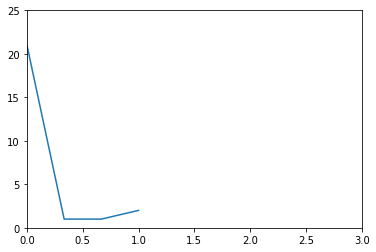

[(0.0, 20), (0.6666666666666666, 4)]
Seconds passed:120


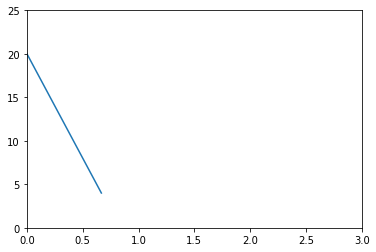

[(0.0, 24)]
Seconds passed:240


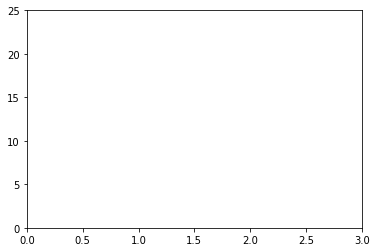

[(0.0, 17), (0.3333333333333333, 5), (0.6666666666666666, 2)]
Seconds passed:360


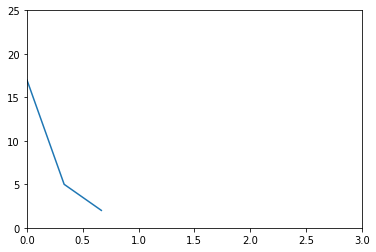

[(0.0, 14), (0.3333333333333333, 8), (0.6666666666666666, 2)]
Seconds passed:480


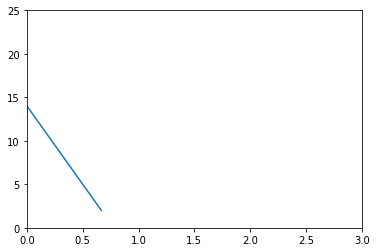

[(0.0, 13), (0.3333333333333333, 5), (0.6666666666666666, 5), (1.0, 1)]
Seconds passed:600


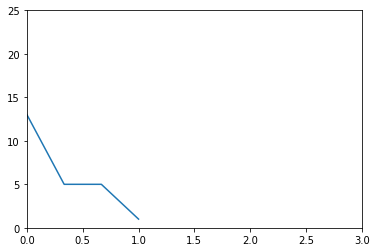

[(0.0, 4), (0.3333333333333333, 8), (0.6666666666666666, 6), (1.0, 4), (1.3333333333333333, 2)]
Seconds passed:720


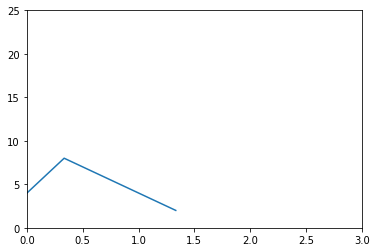

[(0.0, 5), (0.3333333333333333, 11), (0.6666666666666666, 4), (1.0, 2), (1.3333333333333333, 2)]
Seconds passed:840


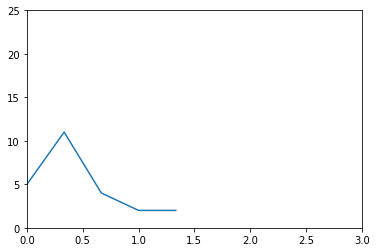

[(0.0, 1), (0.3333333333333333, 4), (0.6666666666666666, 8), (1.0, 5), (1.3333333333333333, 4), (1.6666666666666667, 2)]
Seconds passed:960


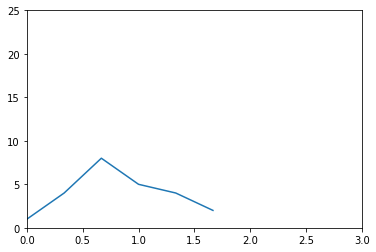

[(0.0, 2), (0.3333333333333333, 6), (0.6666666666666666, 7), (1.0, 8), (1.3333333333333333, 1)]
Seconds passed:1080


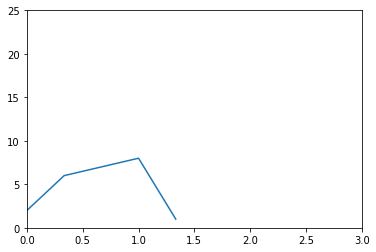

[(0.0, 6), (0.3333333333333333, 5), (0.6666666666666666, 7), (1.0, 4), (1.3333333333333333, 2)]
Seconds passed:1200


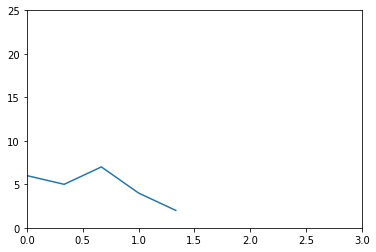

[(0.0, 2), (0.3333333333333333, 5), (0.6666666666666666, 8), (1.0, 3), (1.3333333333333333, 3), (1.6666666666666667, 3)]
Seconds passed:1320


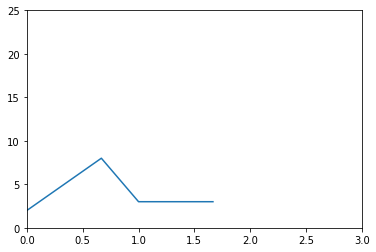

[(0.0, 7), (0.3333333333333333, 4), (0.6666666666666666, 2), (1.0, 7), (1.3333333333333333, 1), (2.0, 1), (2.3333333333333335, 2)]
Seconds passed:1440


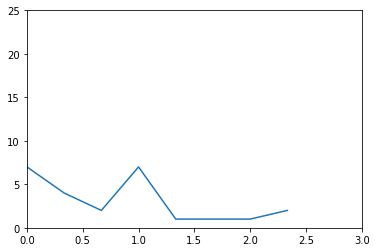

[(0.0, 1), (0.3333333333333333, 11), (0.6666666666666666, 5), (1.0, 1), (1.3333333333333333, 1), (1.6666666666666667, 4), (2.0, 1)]
Seconds passed:1560


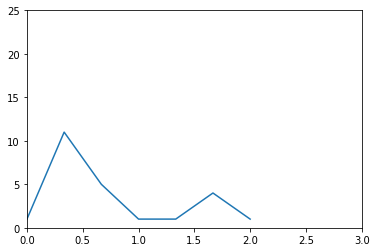

[(0.0, 9), (0.3333333333333333, 7), (0.6666666666666666, 1), (1.0, 2), (1.3333333333333333, 2), (1.6666666666666667, 2), (2.3333333333333335, 1)]
Seconds passed:1680


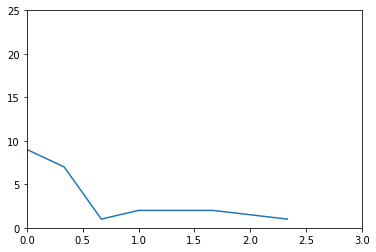

[(0.0, 21), (0.3333333333333333, 3)]
Seconds passed:1800


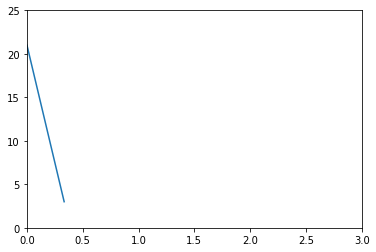

[(0.0, 24)]
Seconds passed:1920


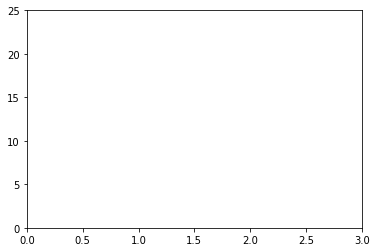

[(0.0, 24)]
Seconds passed:2040


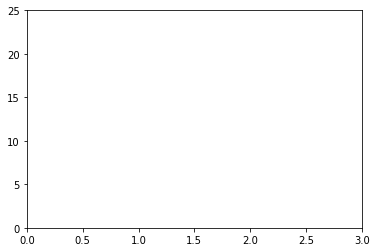

[(0.0, 24)]
Seconds passed:2160


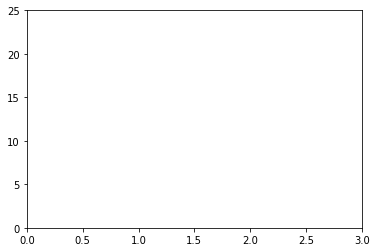

[(0.0, 24)]
Seconds passed:2280


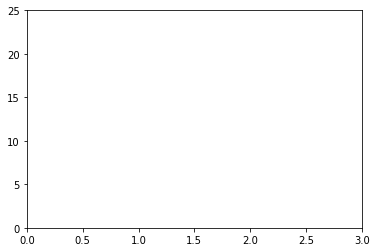

[(0.0, 24)]
Seconds passed:2400


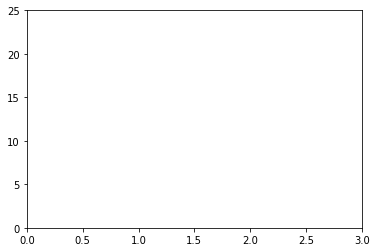

[(0.0, 24)]
Seconds passed:2520


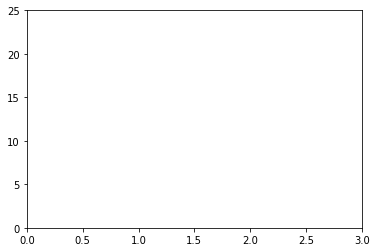

[(0.0, 24)]
Seconds passed:2640


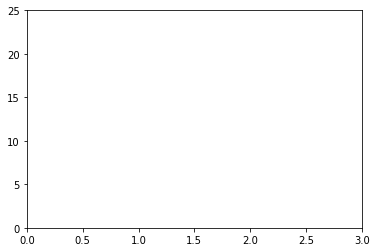

[(0.0, 21), (0.3333333333333333, 3)]
Seconds passed:2760


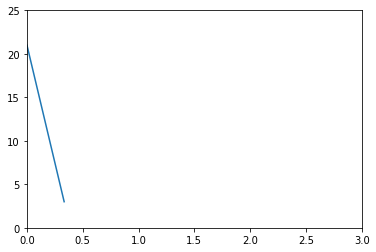

[(0.0, 21), (0.6666666666666666, 3)]
Seconds passed:2880


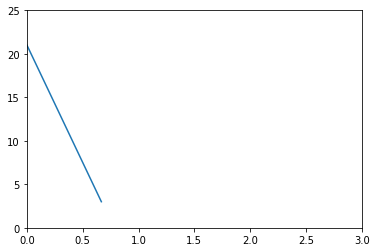

[(0.0, 9), (0.3333333333333333, 4), (0.6666666666666666, 4), (1.0, 2), (1.3333333333333333, 1), (1.6666666666666667, 1), (2.0, 2), (2.3333333333333335, 1)]
Seconds passed:3000


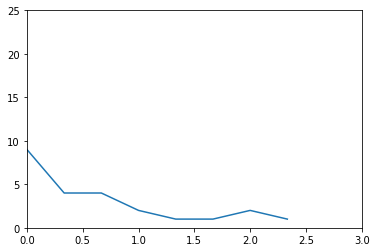

[(0.0, 24)]
Seconds passed:3120


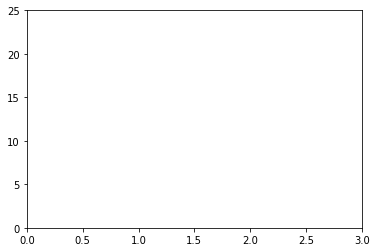

[(0.0, 24)]
Seconds passed:3240


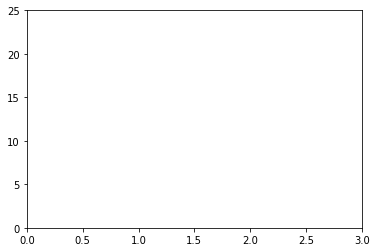

[(0.0, 24)]
Seconds passed:3360


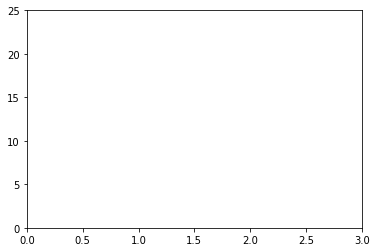

[[[(0.0, 21), (0.3333333333333333, 1), (0.6666666666666666, 1), (1.0, 2)], [(0.0, 20), (0.6666666666666666, 4)], [(0.0, 24)], [(0.0, 17), (0.3333333333333333, 5), (0.6666666666666666, 2)], [(0.0, 14), (0.3333333333333333, 8), (0.6666666666666666, 2)], [(0.0, 13), (0.3333333333333333, 5), (0.6666666666666666, 5), (1.0, 1)], [(0.0, 4), (0.3333333333333333, 8), (0.6666666666666666, 6), (1.0, 4), (1.3333333333333333, 2)], [(0.0, 5), (0.3333333333333333, 11), (0.6666666666666666, 4), (1.0, 2), (1.3333333333333333, 2)], [(0.0, 1), (0.3333333333333333, 4), (0.6666666666666666, 8), (1.0, 5), (1.3333333333333333, 4), (1.6666666666666667, 2)], [(0.0, 2), (0.3333333333333333, 6), (0.6666666666666666, 7), (1.0, 8), (1.3333333333333333, 1)], [(0.0, 6), (0.3333333333333333, 5), (0.6666666666666666, 7), (1.0, 4), (1.3333333333333333, 2)], [(0.0, 2), (0.3333333333333333, 5), (0.6666666666666666, 8), (1.0, 3), (1.3333333333333333, 3), (1.6666666666666667, 3)], [(0.0, 7), (0.3333333333333333, 4), (0.666

In [13]:
#print(spike_data[0])

spike_amounts = []
for channel in spike_data:
  channel_dictionaries = []
  for segment in channel:
    segment_dictionary = {}
    for window in segment:
      try:
        segment_dictionary[window] += 1
      except:
        segment_dictionary[window] = 1
    channel_dictionaries.append(segment_dictionary)
  spike_amounts.append(channel_dictionaries)
print(spike_amounts)

i = 0

#jag plottar en av kanalerna bara for att det ar kul, varje plot ar ett stort window, plotsen som ar tomma har 0 spikes helt och hallet.
for segment in spike_amounts[0]:
  lists = sorted(segment.items()) # sorted by key, return a list of tuples
  print(lists)    #Det som printas här är alltså en lista av tupler (mängd spikes, mängd gånger det har hänt) och den är sorterad efter mängd spikes. 
  x, y = zip(*lists) # unpack a list of pairs into two tuples
  plt.plot(x, y)
  print("Seconds passed:" + str(i))
  i += 120
  plt.ylim((0,25))
  plt.xlim((0,3))
  plt.show()

sorted_spike_amounts = []
for channel in spike_amounts:
  sorted_spike_amounts_channel = []
  for segment in channel:
    lists = sorted(segment.items())
    sorted_spike_amounts_channel.append(lists)
  sorted_spike_amounts.append(sorted_spike_amounts_channel)

print(sorted_spike_amounts) #en lista av kanaler. kanalerna ar listor av stora windows. stora windows ar listor av tupler. tuplerna ar pa formen (mangd spikes i ett litet window(i detta fall 5 sek), antal ganger sa manga spikes har skett i detta lilla window). 
#tuplerna ar sorterade i sina stora windows efter det forsta vardet, alltsa mangden spikes.
#som exempel
#[ [ [(0,5),(1,3)],[(0,3),(2,5)], [(0,1), (1,6)] ],[ [(0,3),(1,4)],[(1,2),(3,4)], [(0,6),(1,10)] ] ]
#i denna har vi 2 kanaler med 3 "stora" windows. I kanal 1, stort window 1 ser vi att 0 spikes har skett i 5 av "sma" windows, 1 spike har skett i 3 av dem. I stort window 2 har 0 spikes skett 0 ggr, 2 spikes 5 ggr, och sa vidare
#ett stort window i vart fall ar 2 minuter, litet ar 5 sekunder.